In [51]:
import pandas as pd

column_names = ['datetime', 'pH']  
ph_dataset = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/ph_log_2025-04-15_18-21-10.csv', header=None, names=column_names)
ph_dataset['unixtime'] = pd.to_datetime(ph_dataset['datetime']).astype('int64') // 10**9

In [52]:
column_names = ['datetime', 'dO'] 
do_dataset_1 = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/do_log_2025-04-16_10-15-56.csv', header=None, names=column_names)
do_dataset_1['unixtime'] = pd.to_datetime(do_dataset_1['datetime']).astype('int64') // 10**9

do_dataset_2 = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/do_log_2025-04-15_18-20-45.csv', header=None, names=column_names)
do_dataset_2['unixtime'] = pd.to_datetime(do_dataset_2['datetime']).astype('int64') // 10**9

merged = pd.merge(do_dataset_1, do_dataset_2, on='unixtime', how='outer', suffixes=('_1', '_2'))
merged['datetime'] = merged['datetime_1'].combine_first(merged['datetime_2'])
merged['Dissolved Oxygen'] = merged['dO_1'].combine_first(merged['dO_2'])
merged_do_dataset = merged[['unixtime', 'datetime', 'Dissolved Oxygen']]

In [53]:
column_names = ['date', 'time', 'Temperature (C)']
temp_dataset = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/temperature_log', header=None, names=column_names)
temp_dataset['datetime'] = pd.to_datetime(temp_dataset['date'] + ' ' + temp_dataset['time'])
temp_dataset['unixtime'] = temp_dataset['datetime'].astype('int64') // 10**9
# temp_dataset = temp_dataset[(temp_dataset['unixtime'] >= start_time) & (temp_dataset['unixtime'] <= end_time)]

In [54]:
column_names = ['datetime', 'red_intensity', 'blue_intensity', 'green_intensity', 'color_combined']  
color_dataset = pd.read_csv('cyano_culture_datasets/04-15-2025 culture/color_log_2025-04-15_18-22-51.txt', header=None, names=column_names)
color_dataset['unixtime'] = pd.to_datetime(color_dataset['datetime']).astype('int64') // 10**9

In [55]:
df_combined = pd.merge(
    merged_do_dataset, ph_dataset, on="unixtime", how="outer", suffixes=("_do", "_ph")
)
df_combined = pd.merge(df_combined, temp_dataset, on="unixtime", how="outer")
df_combined = pd.merge(df_combined, color_dataset, on="unixtime", how="outer")

df_combined = df_combined.sort_values(by="unixtime").reset_index(drop=True)
df_combined["datetime"] = (
    df_combined["datetime_do"]
    .combine_first(df_combined["datetime_ph"])
    .combine_first(df_combined["datetime_x"])
    .combine_first(df_combined["datetime_y"])
)

df_combined = df_combined.drop(
    columns=["datetime_do", "datetime_ph", "datetime_x", "datetime_y", 'date', 'time']
)
desired_order = [
    'unixtime', 'datetime', 'Temperature (C)', 'pH', 'Dissolved Oxygen',
    'red_intensity', 'green_intensity', 'blue_intensity', 'color_combined'
]

df_combined = df_combined[desired_order]

In [56]:
# ADDING A FILTER FOR THE TIME RANGE
start_time = 1744741273  # Replace with your start time in Unix time
end_time = 1745406765  # Replace with your end time in Unix time
df_combined = df_combined[
    (df_combined["unixtime"] >= start_time) & (df_combined["unixtime"] <= end_time)
]

In [57]:
# Convert the datetime column to actual datetime objects
df_combined['datetime'] = pd.to_datetime(df_combined['datetime'])

# Function to calculate light intensity
def get_light_intensity(dt):
    dt = pd.to_datetime(dt)
    hour = dt.hour
    return 120 if 8 <= hour < 20 else 0

# Apply function to create new column
df_combined['Light Intensity (μmol photons m² s⁻¹)'] = df_combined['datetime'].apply(get_light_intensity)
df_combined


,unixtime,datetime,Temperature (C),pH,Dissolved Oxygen,red_intensity,green_intensity,blue_intensity,color_combined,Light Intensity (μmol photons m² s⁻¹)
417112,1744741273,2025-04-15 18:21:13.543205,NaN,7.343,0.00,NaN,NaN,NaN,NaN,120
417113,1744741274,2025-04-15 18:21:14.532573,NaN,7.343,0.00,NaN,NaN,NaN,NaN,120
417114,1744741275,2025-04-15 18:21:15.519331,NaN,7.344,0.00,NaN,NaN,NaN,NaN,120
417115,1744741276,2025-04-15 18:21:16.507702,NaN,7.344,0.00,NaN,NaN,NaN,NaN,120
417116,1744741277,2025-04-15 18:21:17.494259,NaN,7.343,0.00,NaN,NaN,NaN,NaN,120
...,...,...,...,...,...,...,...,...,...,...
1110136,1745406761,2025-04-23 11:12:41.293880,28.98,7.064,7.78,NaN,NaN,NaN,NaN,120
1110137,1745406762,2025-04-23 11:12:42.279130,28.97,7.063,7.78,NaN,NaN,NaN,NaN,120
1110138,1745406763,2025-04-23 11:12:43.266820,28.97,7.062,7.78,NaN,NaN,NaN,NaN,120
1110139,1745406764,2025-04-23 11:12:44.255699,28.98,7.061,7.79,NaN,NaN,NaN,NaN,120


In [58]:
df_combined = df_combined[: -1480] # take off the final bit where the dissolved Oxygne spikes

In [59]:
df_combined.to_csv(
    'cyano_culture_datasets/04-15-2025 culture/combined_dataset.csv',
    index=False
)

In [60]:
import numpy as np
I_0 = df_combined['red_intensity'].max()
def calculate_od_from_red_intensity(red_intensity, I0 = I_0):
    if pd.isna(red_intensity):
        return np.nan
    # Replace with your actual formula. For example:
    if red_intensity <= 0: return np.nan
    return -np.log10(red_intensity / I0)

df_combined['Optical Density (620 nm - 750 nm)'] = df_combined['red_intensity'].apply(calculate_od_from_red_intensity)



/var/folders/w8/skrhf2l569j8bp_zxp38dpn40000gn/T/ipykernel_21767/2646612666.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['Optical Density (620 nm - 750 nm)'] = df_combined['red_intensity'].apply(calculate_od_from_red_intensity)


# What's the data look like?

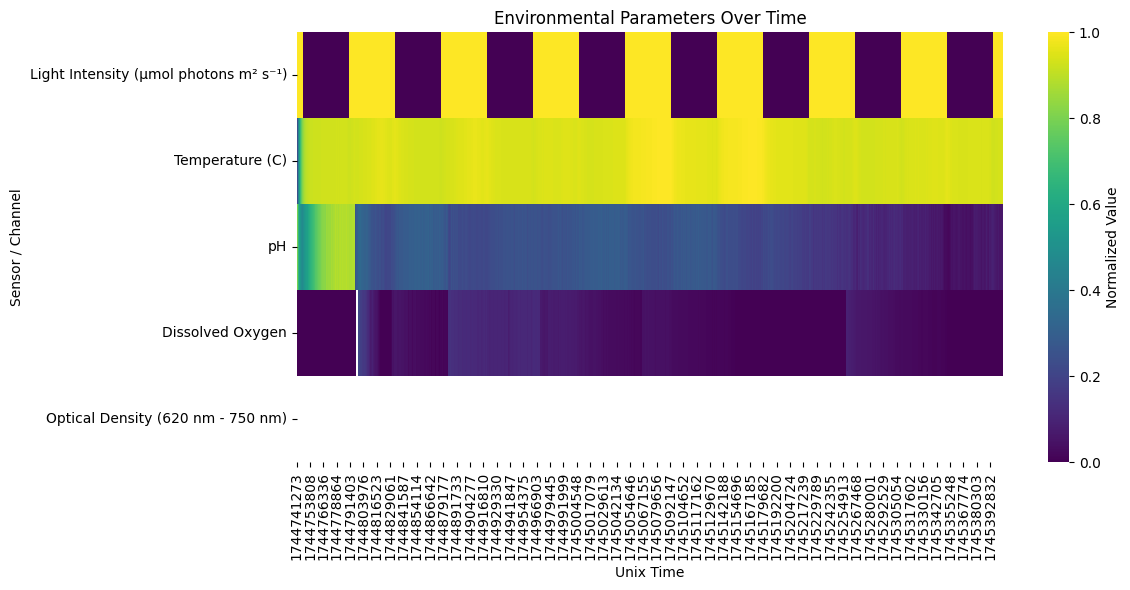

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = df_combined[
    [
        'unixtime',
        'Light Intensity (μmol photons m² s⁻¹)',
        "Temperature (C)",
        "pH",
        "Dissolved Oxygen",
        "Optical Density (620 nm - 750 nm)",
        # "green_intensity",
        # "blue_intensity",
    ]
]
heatmap_data = heatmap_data.dropna(how="all")
heatmap_data = heatmap_data.set_index("unixtime")
normalized = (heatmap_data - heatmap_data.min()) / (
    heatmap_data.max() - heatmap_data.min()
)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(
    normalized.transpose(), cmap="viridis", cbar_kws={"label": "Normalized Value"}
)
plt.xlabel("Unix Time")
plt.ylabel("Sensor / Channel")
plt.title("Environmental Parameters Over Time")
plt.tight_layout()
plt.show()

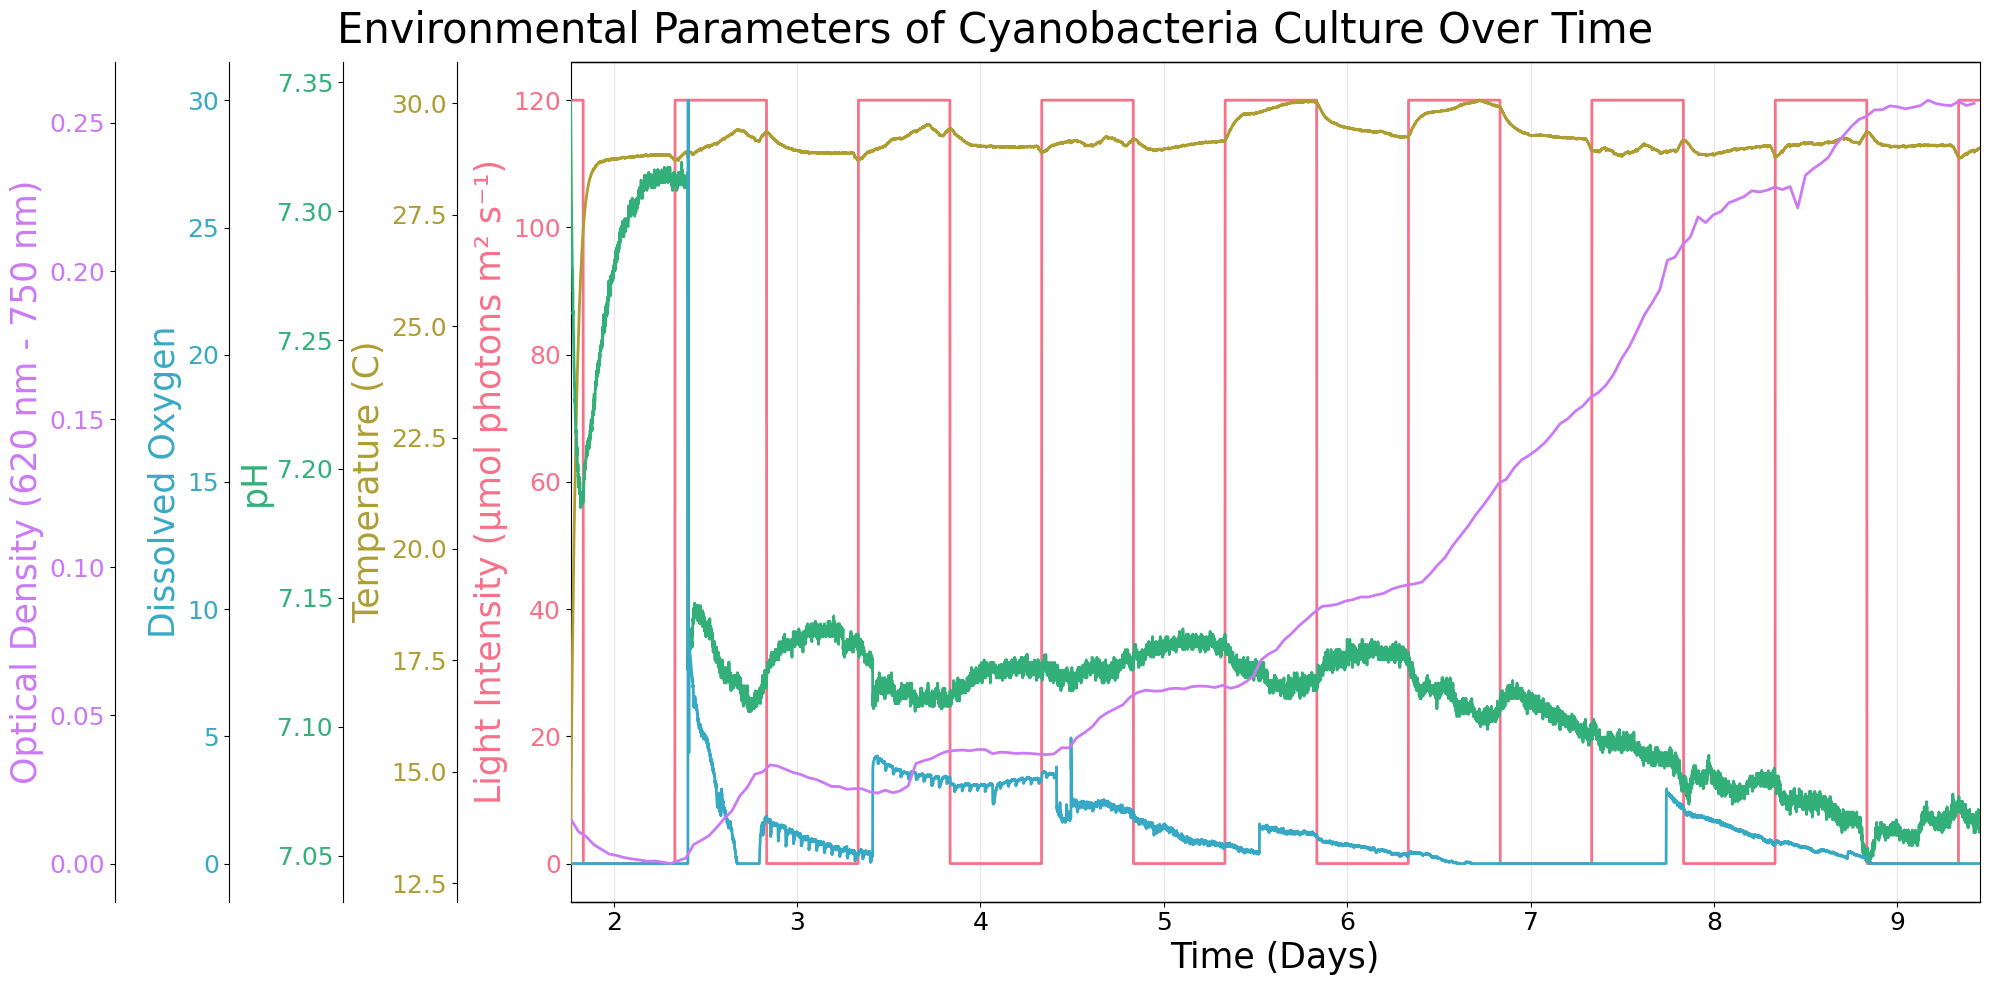

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare the data
lineplot_data = df_combined[[
    'unixtime',
    'Light Intensity (μmol photons m² s⁻¹)',
    'Temperature (C)',
    'pH',
    'Dissolved Oxygen',
    'Optical Density (620 nm - 750 nm)',
]].copy()

# 2. Optional downsampling
for col in ['Light Intensity (μmol photons m² s⁻¹)', 'Temperature (C)', 'pH', 'Dissolved Oxygen']:
    if col in lineplot_data:
        s = lineplot_data[col]
        ds = pd.Series(np.nan, index=s.index, dtype=s.dtype)
        ds.iloc[::50] = s.iloc[::50]
        lineplot_data[col] = ds

lineplot_data = lineplot_data.dropna(how='all')

# 3. Convert unixtime → datetime index, add timestamp & day numbers
lineplot_data['timestamp'] = pd.to_datetime(lineplot_data['unixtime'], unit='s')
lineplot_data = lineplot_data.set_index('timestamp')
lineplot_data['day_number'] = (
    lineplot_data.index.floor('D') - lineplot_data.index.floor('D')[0]
).days + 1
lineplot_data = lineplot_data.drop(columns=['unixtime'])

# 4. Choose which columns to plot
columns_to_plot = [c for c in lineplot_data.columns if c not in ['day_number']]

# 5. Set up the figure
fig, ax1 = plt.subplots(figsize=(20, 10))
palette = sns.color_palette("husl", len(columns_to_plot))

# 6. Plot the first variable
ax1.set_xlabel('Time (Days)', fontsize=25)
ax1.set_ylabel(columns_to_plot[0], color=palette[0], fontsize=25)
sns.lineplot(
    data=lineplot_data.dropna(subset=[columns_to_plot[0]]),
    x='timestamp',
    y=columns_to_plot[0],
    ax=ax1,
    color=palette[0],
    linewidth=2,
    legend=False
)
ax1.tick_params(axis='y', labelcolor=palette[0], labelsize=18)
ax1.tick_params(axis='x', labelsize=20)
ax1.grid(True, axis='x', alpha=0.3)
# 7. Customize x‐ticks: one tick per day labeled 1, 2, 3...
# 7. Customize x‐ticks: force Day 1 to be included
start_time = lineplot_data.index.min()
end_time = lineplot_data.index.max()

# Generate daily tick positions starting from midnight
day_starts = pd.date_range(start=start_time.normalize(), end=end_time.normalize(), freq='D')

# If the first timestamp isn't exactly midnight, prepend it
if start_time < day_starts[0]:
    day_starts = day_starts.insert(0, start_time)

# Match labels to number of ticks
labels = np.arange(1, len(day_starts) + 1)

ax1.set_xticks(day_starts)
ax1.set_xticklabels(labels, fontsize=18)
ax1.set_xlim(start_time, end_time)

# 8. Plot remaining variables on left-offset twin y-axes
for i, col in enumerate(columns_to_plot[1:], start=1):
    ax_new = ax1.twinx()
    color = palette[i]

    # Move axis to the left
    ax_new.spines["right"].set_visible(False)
    ax_new.spines["left"].set_visible(True)
    ax_new.spines["left"].set_position(("outward", 82 * i))

    # ⬅️ Ensure label and ticks are drawn on the left
    ax_new.yaxis.set_label_position('left')
    ax_new.yaxis.tick_left()

    ax_new.set_ylabel(col, color=color, fontsize=25)

    sns.lineplot(
        data=lineplot_data.dropna(subset=[col]),
        x='timestamp',
        y=col,
        ax=ax_new,
        color=color,
        linewidth=2,
        legend=False
    )

    ax_new.tick_params(axis='y', labelcolor=color, labelsize=18)
    ax_new.grid(False)

# 9. Final touches
fig.suptitle('Environmental Parameters of Cyanobacteria Culture Over Time', fontsize=30)
plt.tight_layout()
plt.show()


# Fun little exercise to try and look thru only the columns that have complete data for correlation matrix

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select the columns we're interested in
correlation_data = df_combined[
    [
        'Light Intensity (μmol photons m² s⁻¹)',
        "Temperature (C)",
        "pH",
        "Dissolved Oxygen",
        "Optical Density (620 nm - 750 nm)",
    ]
]

# Drop rows with any missing values
complete_data = correlation_data.dropna(how="any")
complete_data


,Light Intensity (μmol photons m² s⁻¹),Temperature (C),pH,Dissolved Oxygen,Optical Density (620 nm - 750 nm)
417229,120,13.57,7.334,0.0,0.014973
420984,120,24.84,7.195,0.0,0.010775
424749,0,27.86,7.205,0.0,0.009115
428512,0,28.52,7.227,0.0,0.006383
432274,0,28.68,7.250,0.0,0.004817
...,...,...,...,...,...
1090751,0,29.04,7.062,0.0,0.256091
1094514,0,29.04,7.065,0.0,0.255861
1098272,120,28.77,7.070,0.0,0.257291
1102024,120,28.85,7.066,0.0,0.255884


Original shape: (691549, 5), After dropping NAs: (192, 5)


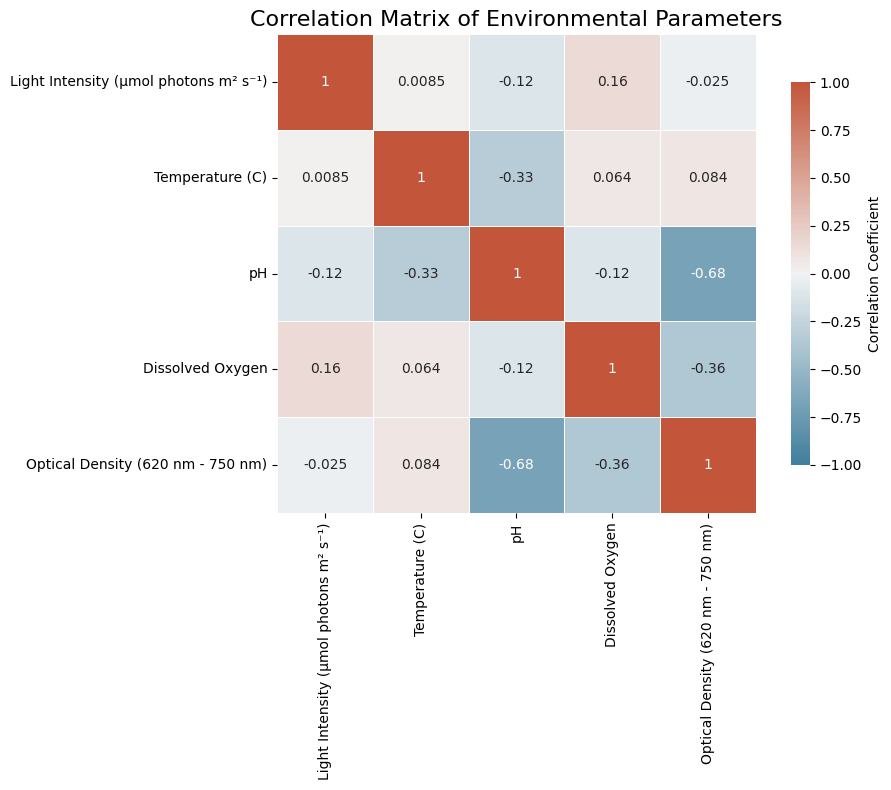


Correlation Matrix:
                                       Light Intensity (μmol photons m² s⁻¹)  \
Light Intensity (μmol photons m² s⁻¹)                                   1.00   
Temperature (C)                                                         0.01   
pH                                                                     -0.12   
Dissolved Oxygen                                                        0.16   
Optical Density (620 nm - 750 nm)                                      -0.02   

                                       Temperature (C)    pH  \
Light Intensity (μmol photons m² s⁻¹)             0.01 -0.12   
Temperature (C)                                   1.00 -0.33   
pH                                               -0.33  1.00   
Dissolved Oxygen                                  0.06 -0.12   
Optical Density (620 nm - 750 nm)                 0.08 -0.68   

                                       Dissolved Oxygen  \
Light Intensity (μmol photons m² s⁻¹)              0.1

<Figure size 1200x1000 with 0 Axes>

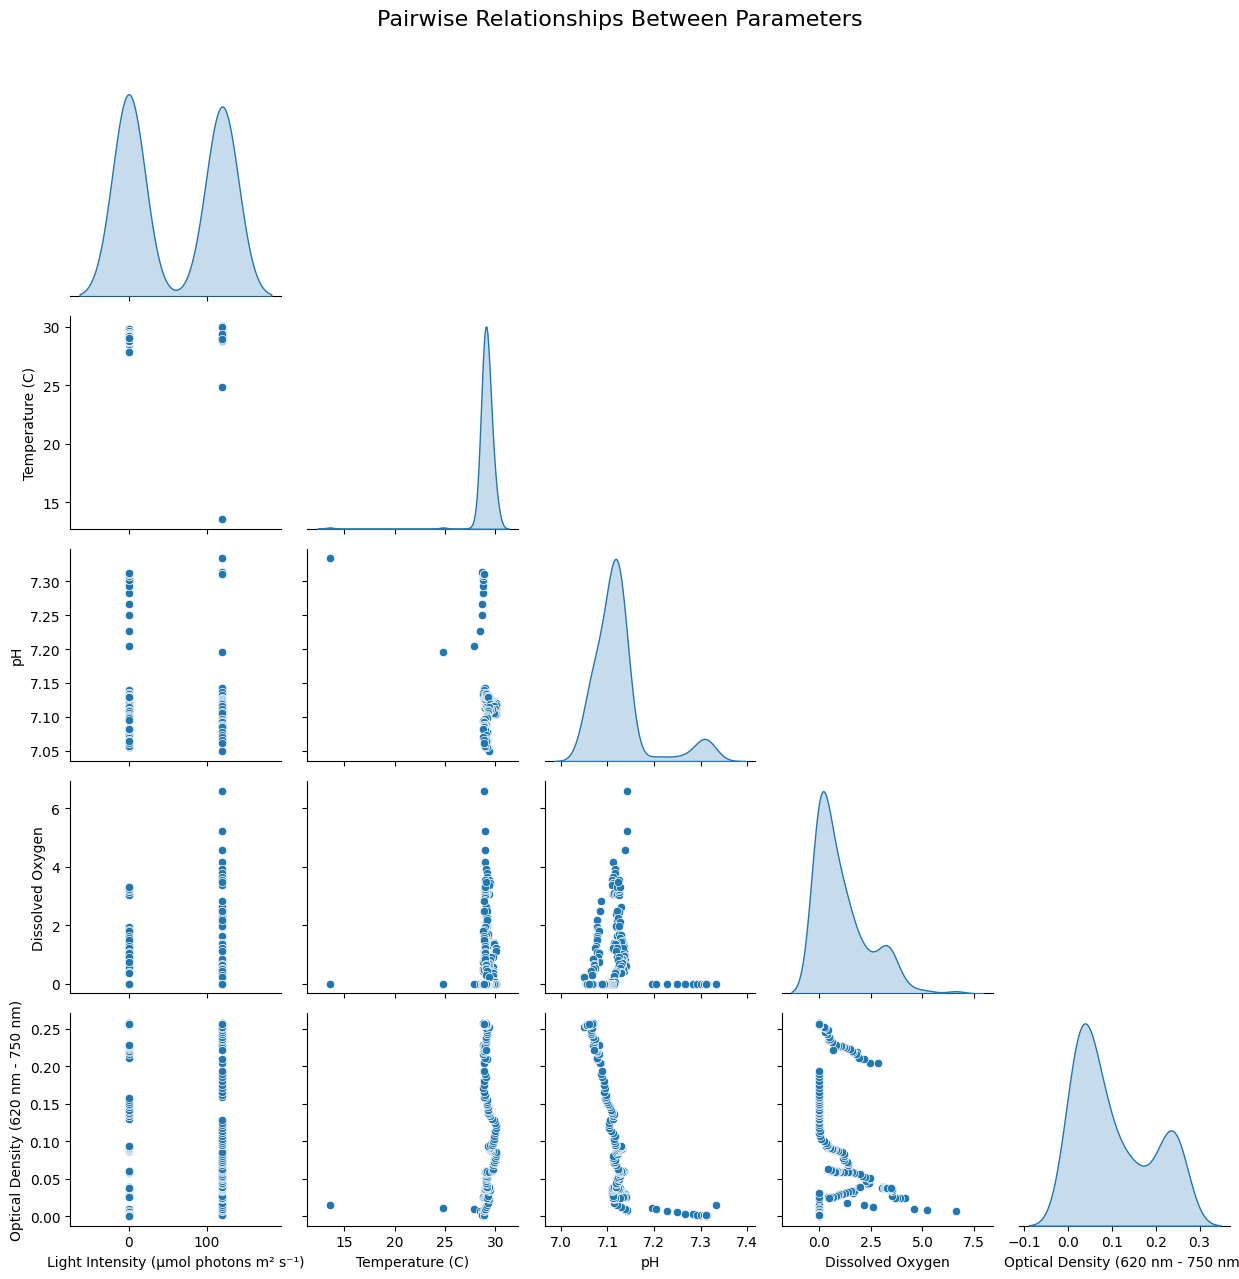

In [64]:
print(f"Original shape: {correlation_data.shape}, After dropping NAs: {complete_data.shape}")

# Calculate the correlation matrix
corr_matrix = complete_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with formatting
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create a mask for the upper triangle
cmap = sns.diverging_palette(230, 20, as_cmap=True)  # Use a diverging colormap

# Draw the heatmap
sns.heatmap(
    corr_matrix, 
    annot=True,  # Show correlation values
    cmap=cmap,   # Use our defined colormap
    vmax=1.0,    # Maximum correlation value
    vmin=-1.0,   # Minimum correlation value
    center=0,    # Center the colormap at zero
    square=True, # Make the cells square
    linewidths=.5,
    cbar_kws={"shrink": .8, "label": "Correlation Coefficient"}
)

plt.title('Correlation Matrix of Environmental Parameters', fontsize=16)
plt.tight_layout()
plt.show()

# Let's also look at the actual correlation values
print("\nCorrelation Matrix:")
print(corr_matrix.round(2))

# Additional analysis: descriptive statistics of complete data
print("\nDescriptive Statistics:")
print(complete_data.describe())

# You could also do a pairplot to see both distributions and correlations
plt.figure(figsize=(12, 10))
sns.pairplot(complete_data, diag_kind='kde', corner=True)
plt.suptitle('Pairwise Relationships Between Parameters', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()